# Inspect raw data
This notebook can be used to assess how many trials are missing in the EEG data set of one participant.

In [1]:
import mne
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
path = "/scratch/data/2024FreeViewingMSCOCO/sub-033/ses-001/eeg/sub-033_ses-001_task-2024FreeViewingMSCOCO_eeg.set"
path_gap = "/scratch/backup/gap_test.set"

raw = mne.io.read_raw_eeglab(path_gap)

/tmp/ipykernel_1722332/1269013251.py:4: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(path_gap)


In [3]:
# raw.plot()

In [4]:
# all_events, all_event_id = mne.events_from_annotations(raw)
# mne.viz.plot_events(events=all_events, event_id=all_event_id, sfreq=raw.info["sfreq"])

## Find missing data segments in the EEG data

In [5]:
eeg_data = raw.get_data(units="uV")
sample_nr = eeg_data[-1,:] # The last "channel" in the eeg_data is the sample number

In [6]:
def find_missing_data_segments(data):
    start_missing = []
    end_missing = []

    # Check whether first sample is nan (if yes add to start)
    if np.isnan(data[0]):
        start_missing.append(0)
        if (not np.isnan(data[1])):
            end_missing.append(0)
    # Find transitions between existing values and nan-values
    for i in range(1,len(data)-1):
        if (np.isnan(data[i]) and not np.isnan(data[i-1])):
            start_missing.append(i)
        if (np.isnan(data[i]) and not np.isnan(data[i+1])):
            end_missing.append(i)

    # Check whether last sample is nan (if yes add to end)
    if np.isnan(data[-1]):
        end_missing.append(len(data)-1)
        if (not np.isnan(data[-2])):
            start_missing.append(len(data)-1)

    return start_missing, end_missing

In [7]:
start_idx, end_idx = find_missing_data_segments(sample_nr)

In [9]:
missing_segments = pd.DataFrame({
    'start_idx': start_idx,
    'end_idx': end_idx,
    'start_time': raw.times[start_idx],
    'end_time': raw.times[end_idx]})

In [11]:
missing_segments['duration'] = missing_segments['end_time']-missing_segments['start_time']
missing_segments

,start_idx,end_idx,start_time,end_time,duration
0,2048062,2333673,2048.062,2333.673,285.611
1,3086455,3225484,3086.455,3225.484,139.029
2,3761113,4894002,3761.113,4894.002,1132.889


## Count number of trials (images shown) within the missing eeg data segments

In [12]:
events = raw.annotations.to_data_frame()

In [13]:
events["onset_seconds"] = events.onset.apply(lambda x: x.timestamp())
events

,onset,duration,description,onset_seconds
0,1970-01-01 00:00:00.910506,0.0,3-128@236225,0.910506
1,1970-01-01 00:00:01.912075,0.0,3-128@237225,1.912075
2,1970-01-01 00:00:02.912643,0.0,3-128@238225,2.912643
3,1970-01-01 00:00:03.912163,0.0,3-128@239225,3.912163
4,1970-01-01 00:00:04.910607,0.0,3-128@240225,4.910607
...,...,...,...,...
5032,1970-01-01 01:36:06.462959,0.0,3-128@874008,5766.462959
5033,1970-01-01 01:36:07.462601,0.0,3-128@875008,5767.462601
5034,1970-01-01 01:36:08.461404,0.0,3-128@876008,5768.461404
5035,1970-01-01 01:36:09.460893,0.0,3-128@877008,5769.460893


In [14]:
stim_shown_df = events[events["description"].str.contains("trigger=02")]
stim_shown_df

,onset,duration,description,onset_seconds
91,1970-01-01 00:01:30.405826,0.0,1-trigger=02 Stimulus image shown | block=0 | ...,90.405826
102,1970-01-01 00:01:38.371523,0.0,1-trigger=02 Stimulus image shown | block=0 | ...,98.371523
113,1970-01-01 00:01:46.564983,0.0,1-trigger=02 Stimulus image shown | block=0 | ...,106.564983
543,1970-01-01 00:08:50.622947,0.0,1-trigger=02 Stimulus image shown | block=1 | ...,530.622947
555,1970-01-01 00:08:58.998117,0.0,1-trigger=02 Stimulus image shown | block=1 | ...,538.998117
...,...,...,...,...
4773,1970-01-01 01:32:04.057198,0.0,1-trigger=02 Stimulus image shown | block=5 | ...,5524.057198
4784,1970-01-01 01:32:11.826591,0.0,1-trigger=02 Stimulus image shown | block=5 | ...,5531.826591
4796,1970-01-01 01:32:20.766922,0.0,1-trigger=02 Stimulus image shown | block=5 | ...,5540.766922
4806,1970-01-01 01:32:27.975031,0.0,1-trigger=02 Stimulus image shown | block=5 | ...,5547.975031


In [15]:
# Function to count how many images were shown in the time window that has missing EEG data
def count_missing_trials(start_time, end_time, stim_shown_events):
    return stim_shown_events.query("(onset_seconds >= @start_time) & (onset_seconds <= @end_time)").shape[0]
    

In [16]:
missing_segments.loc[:, "count_missing_trials"] = missing_segments.apply(lambda row: count_missing_trials(row["start_time"], row["end_time"], stim_shown_df), axis=1)
missing_segments

,start_idx,end_idx,start_time,end_time,duration,count_missing_trials
0,2048062,2333673,2048.062,2333.673,285.611,0
1,3086455,3225484,3086.455,3225.484,139.029,0
2,3761113,4894002,3761.113,4894.002,1132.889,39


## Overview of missing trials
Trials could be either missing because the EEG stream broke off (`total_missing_in_segments`) or because the experiment was aborted early (`additional_missing_trials`).

In [17]:
# 400 trials during the experiment + 3 practice trials
total_nr_trials = 400 + 3

# Count how many images (trials) were shown during interruption of the EEG stream and thereby have no EEG data
total_missing_in_segments = missing_segments.count_missing_trials.sum()

# For example if the experiment was aborted early and not all images were shown
additional_missing_trials = total_nr_trials - stim_shown_df.shape[0]

# Calculate total number of missing trials (absolute and relative)
total_num_missing_trials = total_missing_in_segments + additional_missing_trials
percentage_missing = round(total_num_missing_trials/total_nr_trials * 100, 2)

In [18]:
missing_trials_info = {
    "missing_segments_df": missing_segments,
    "total_missing_in_segments": total_missing_in_segments,
    "additional_missing_trials": additional_missing_trials,
    "total_num_missing_trials": total_num_missing_trials,
    "percentage_missing": percentage_missing
}
missing_trials_info

{'missing_segments_df':    start_idx  end_idx  start_time  end_time  duration  count_missing_trials
 0    2048062  2333673    2048.062  2333.673   285.611                     0
 1    3086455  3225484    3086.455  3225.484   139.029                     0
 2    3761113  4894002    3761.113  4894.002  1132.889                    39,
 'total_missing_in_segments': 39,
 'additional_missing_trials': 150,
 'total_num_missing_trials': 189,
 'percentage_missing': 46.9}

In [29]:
# In case one wants to check which trials are (not) missing, one can start with this code
#import re
#stim_shown_df.loc[:,"trial_nr"] = stim_shown_df.description.apply(lambda row: int(re.search(r'trial=-?\d+', row).group().split('=')[1]))
#stim_shown_df

## Visualization of missing EEG data segments

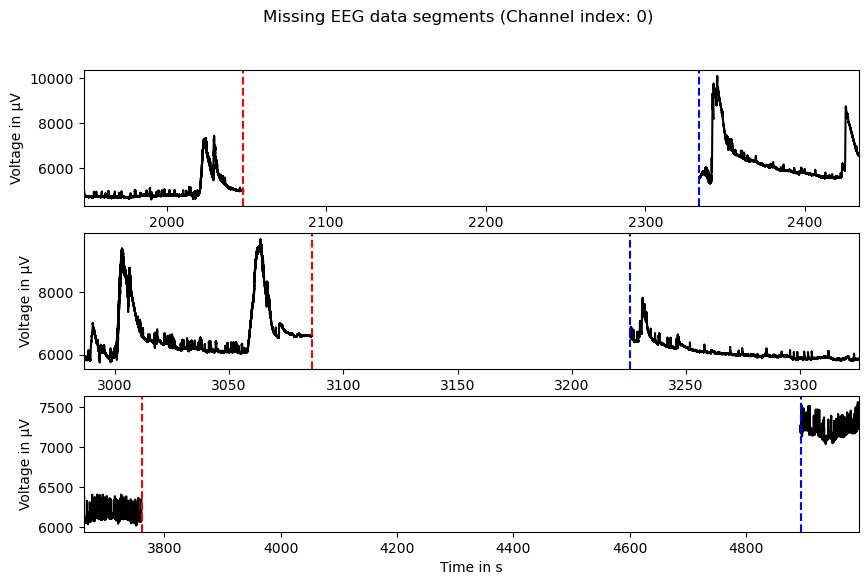

In [35]:
window_size = 100000 # in samples
channel_idx = 0 # Can be changed if one wants to inspect the missing segments for another channel
nr_segments = len(missing_segments)
fig, axes = plt.subplots(nrows=nr_segments, ncols=1, figsize=(10, 6))
fig.suptitle(f"Missing EEG data segments (Channel index: {channel_idx})")

for s, ax in enumerate(axes):
    start_plot = missing_segments.loc[s, "start_idx"] - window_size
    end_plot = missing_segments.loc[s, "end_idx"] + window_size
    
    ax.plot(raw.times[start_plot:end_plot],eeg_data[channel_idx, start_plot:end_plot], color='k')
    ax.axvline(x=raw.times[missing_segments.loc[s, "start_idx"]], color='r', linestyle='--')
    ax.axvline(x=raw.times[missing_segments.loc[s, "end_idx"]], color='b', linestyle='--')
    ax.set_xlim((raw.times[start_plot],raw.times[end_plot]))
    ax.set_xlabel("Time in s")
    ax.set_ylabel("Voltage in μV")
plt.show()

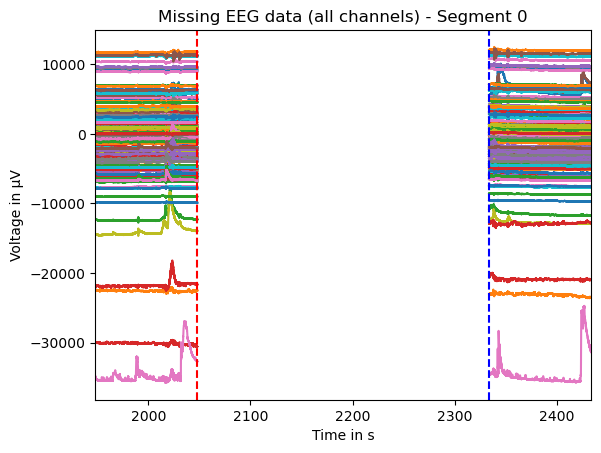

In [37]:
window_size = 100000 # in samples
segment_idx = 0 # Can be changed if one wants to inspect another missing segment

#for s, ax in enumerate(axes):
start_plot = missing_segments.loc[segment_idx, "start_idx"] - window_size
end_plot = missing_segments.loc[segment_idx, "end_idx"] + window_size

for r in range(eeg_data[:-1,:].shape[0]):
    plt.plot(raw.times[start_plot:end_plot],eeg_data[r, start_plot:end_plot])

plt.axvline(x=raw.times[missing_segments.loc[segment_idx, "start_idx"]], color='r', linestyle='--')
plt.axvline(x=raw.times[missing_segments.loc[segment_idx, "end_idx"]], color='b', linestyle='--')
plt.xlim((raw.times[start_plot],raw.times[end_plot]))
plt.xlabel("Time in s")
plt.ylabel("Voltage in μV")
plt.title(f"Missing EEG data (all channels) - Segment {segment_idx}")
plt.show()

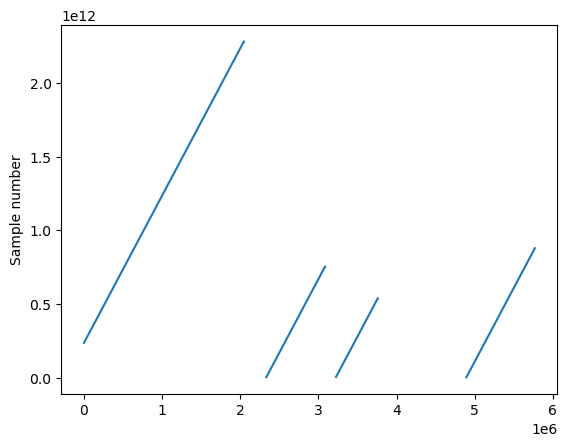

In [38]:
plt.plot(eeg_data[-1,:])
plt.ylabel("Sample number")
plt.show()